# PyTorch Presentation Code Examples

CSCI 5448 <br>
Graduate Presentation <br>
15 April 2019 <br>
By: Dieu My Nguyen

In [280]:
# Of course, we always import numpy, pandas, & matplotlib
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Some other useful imports
from sklearn.metrics import confusion_matrix

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
torch.set_printoptions(linewidth=120)

## Tensor and basic operations

#### Construct a tensor from a list or sequence using the ```torch.tensor()``` constructor.

In [281]:
torch.tensor([[0, 1], [2, 3]])

tensor([[0, 1],
        [2, 3]])

In [282]:
torch.tensor(np.array([[1, 2, 3], [4, 5, 6]]))

tensor([[1, 2, 3],
        [4, 5, 6]])

#### Make a tensor of a specific data type by passing a ```torch.dtype``` to a constructor or tensor creation op.

In [283]:
torch.zeros([2, 4], dtype=torch.int32)

tensor([[0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=torch.int32)

#### Access and modify contents of a tensor by using Python's normal indexing and slicing notation.

In [284]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(x[1][2])

tensor(6)


In [285]:
x[0][1] = 8
print(x)

tensor([[1, 8, 3],
        [4, 5, 6]])


#### Shape, reshape, squeeze, flatten, concatenate.

In [14]:
t = torch.tensor([
    [1, 1, 1, 1],
    [2, 2, 2, 2],
    [3, 3, 3, 3]
], dtype=torch.float32)

In [15]:
# Get shape either way
t.size(), t.shape

(torch.Size([3, 4]), torch.Size([3, 4]))

In [16]:
# Get number of elements in tensor
t.numel()

12

In [17]:
# Reshape a tensor
t.reshape([1, 12])

tensor([[1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.]])

In [26]:
# Squeeze, unsqueeze a tensor. Notice the shape changes.

print("Original reshape:")
print(t.reshape([1, 12]))
print(t.reshape([1, 12]).shape)

print("\nSqueeze:")
print(t.reshape([1,12]).squeeze())
print(t.reshape([1,12]).squeeze().shape)

print("\nUnsqueeze:")
print(t.reshape([1,12]).squeeze().unsqueeze(dim=0))
print(t.reshape([1,12]).squeeze().unsqueeze(dim=0).shape)

Original reshape:
tensor([[1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.]])
torch.Size([1, 12])

Squeeze:
tensor([1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.])
torch.Size([12])

Unsqueeze:
tensor([[1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.]])
torch.Size([1, 12])


In [29]:
# Flatten a tensor
t = t.reshape(1, -1)
t = t.squeeze()
print(t)
print(t.shape)

tensor([1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.])
torch.Size([12])


In [37]:
# Concentenate tensors
t1 = torch.tensor([
    [1, 2],
    [3, 4]
])

t2 = torch.tensor([
    [5, 6],
    [7, 7]
])

# Concat row wise
print(f"Row wise concat: \n{torch.cat((t1, t2), dim=0)}")

# Concat column wise
print(f"\nColumn wise concat: \n{torch.cat((t1, t2), dim=1)}")

Row wise concat: 
tensor([[1, 2],
        [3, 4],
        [5, 6],
        [7, 7]])

Column wise concat: 
tensor([[1, 2, 5, 6],
        [3, 4, 7, 7]])


## Fashion-MNIST CNN Example

Four primary steps:
1. Prepare the data
2. Build the CNN model
3. Train the model
4. Analyze the model’s results

### 1. Prepare data using PyTorch

Steps:
1. Extract: Get image data from source
2. Transform: Put data into tensor form
3. Load: Put data into object to make it easily accessible

For these steps, PyTorch gives us 2 classes: 
- ```torch.utils.data.Dataset```: An abstract class to represent a dataset. We extend ```Dataset``` to create a concerete subclass.
- ```torch.utils.data.DataLoader```: Wraps a dataset and provide access to the underlying data

Since Fashion-MNIST comes with ```torchvision```, we just need to know that under the hood: All subclasses of the ```Dataset``` class must override ```__len__```, which provides the size of the dataset, and ```__getitem__```, supporting integer indexing in range from 0 to ```len(self)``` exclusive.

Let's get an instance of the dataset using ```torchvision``` by specifying the following arguments:

- ```root```: The location on disk where the data is located.
- ```train```: If the dataset is the training set.
- ```download```: If the data should be downloaded.
- ```transform```: A composition of transformations that should be performed on the dataset elements.

We use the built-in ```transforms.ToTensor()``` transformation to transform our images into tensors. 

In [288]:
train_set = torchvision.datasets.FashionMNIST(
            root='./data/FashionMNIST',
            train=True,
            download=True,
            transform=transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.FashionMNIST(
            root='./data/FashionMNIST',
            train=False,
            download=True,
            transform=transforms.Compose([transforms.ToTensor()]))

Next, let's create a ```DataLoader``` wrapper for the training and testing sets. 

In [289]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_set,
                                           batch_size=batch_size,
                                           shuffle=True)

Explore the dataset with simple Python and PyTorch functions:

In [290]:
# See how images in train/test sets
len(train_set), len(test_set)

(60000, 10000)

In [291]:
# See labels for images
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [292]:
# See distribution of labels: Balanced dataset so let's no worry about 
# the common problem of class imabalance
train_set.targets.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

Access data in the train set:

In [293]:
# Pass train_set object to Python built-in iter() function
# Returns an object representing a stream of data
# Built-in next() gets us the next data element in the stream
sample = next(iter(train_set))
len(sample)  # 2 items represent image-label pair for each sample

2

In [294]:
# Index sample to get image and label
image = sample[0]
label = sample[1]

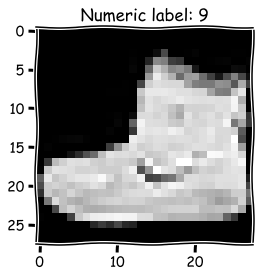

In [295]:
# Plot the image 
plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Numeric label: {label}")
plt.show()

Working with batches of data: 

In [303]:
display_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

In [304]:
# Use iter() and next() again to grab this batch from the data
batch = next(iter(display_loader))
images, labels = batch

In [305]:
# Look at tensor shape: 
# We have 10 images, each has 1 color channel of size 28x28
print('Shapes:', images.shape, labels.shape)

Shapes: torch.Size([10, 1, 28, 28]) torch.Size([10])


Labels: tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5])


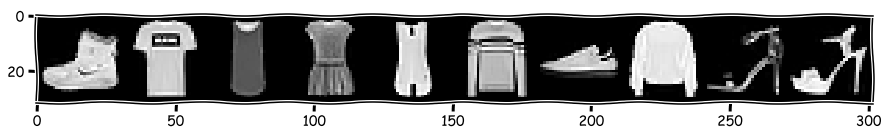

In [306]:
# Plot a batch of images, use torchvision.utils.make_grid()
grid_img = torchvision.utils.make_grid(images, nrow=10, pad_value=0, padding=2)
plt.figure(figsize=(15,15))
plt.imshow(grid_img.permute(1,2,0))
print('Labels:', labels)

### 2. Build the CNN model

CNNs are the go-to networks for image recognition/classification tasks because they're well suited for detecting spacial patterns. 

#### Shape of a CNN input:

Typically, the shape of the input is 4 (axes). Let's go backward to explore each axis.

<i> Image height and width: </i> These are represented on the last 2 axes. For Fashion-MNIST, we'd have 28x28. 

<i> Image color channels: </i> For RGB, we have 3, or 1 for grayscale, in the next axis. This color channel interpretation only applies to the input tensor. The interpretation of this axis changes after the tensor passes through a convolutional layer. 

<i> Image batches: </i> The first axis. In neural networks, we usually work with batches of samples opposed to single samples, so the length of this axis tells us how many samples are in our batch.

This allows us to see that an entire batch of images is represented using a single rank-4 tensor.

For example, we have a tensor of the shape ```[3, 1, 28, 28]```. We have a batch of 3 images, each image has a single color channel and are of height and width 28x28. The tensor is [Batch, Channels, Height, Width]. To navigate to a specific pixel in a specific color channel, we'd use 4 indexes.

#### Output channels and feature maps:

After the tensor is transformed by a convolutional layer, the shape of the image tensor will change. The convolution changes the height and width dimensions as well as the number of channels. The number of output channels changes based on the number of filters being used in the convolutional layer.

Suppose we have three convolutional filters, and lets just see what happens to the channel axis.

Since we have three convolutional filters, we will have three channel outputs from the convolutional layer. These channels are outputs from the convolutional layer, hence the name output channels opposed to color channels.

Each of the three filters convolves the original single input channel producing three output channels. The output channels are still comprised of pixels, but the pixels have been modified by the convolution operation. Depending on the size of the filter, the height and width dimensions of the output will change also.

<i> Feature maps:</i> With the output channels, we no longer have color channels, but modified channels that we call feature maps. These so-called feature maps are the outputs of the convolutions that take place using the input color channels and the convolutional filters.

The word “feature” is used because the outputs represent particular features from the image, like edges for example, and these mappings emerge as the network learns during the training process and become more complex as we move deeper into the network.



#### Object-oriented neural networks

To build NNs in PyTorch, we extend the ```torch.nn.Module``` class from PyTorch.

Each layer is a great candidate to be represented as objects using OOP, as each had 2 primary components: A transformation (code) and a collection of weights (data). Within PyTorch ``nn`` package, there is a class called ```Module``` and it is the base class for all NN modules iuncluding layers.

All layers (aka a neural network) extend/inherit from ```nn.Module```.

```nn.Module``` has a ```forward()``` method. When we pass a tensor to our network as input, the tensor flows forward though each layer transformation until the tensor reaches the output layer. 

The goal of the overall transformation is to transform or map the input to the correct prediction output class, and during the training process, the layer weights (data) are updated in such a way that cause the mapping to adjust to make the output closer to the correct prediction.

When we implement the ```forward()``` method of our ```nn.Module``` subclass, we will typically use functions from the ```nn.functional``` package. This package provides us with many neural network operations that we can use for building layers. In fact, many of the ```nn.Module``` layer classes use ```nn.functional``` functions to perform their operations.

The ```nn.functional``` package contains methods that subclasses of ```nn.Module``` use for implementing their ```forward()``` functions. Later, we see an example of this by looking at the PyTorch source code of the ```nn.Conv2d``` convolutional layer class.

#### Now we can build a neural net!

1. Create a neural network class that extends the ```nn.Module``` base class.
2. In the class constructor, define the network’s layers as class attributes using pre-built layers from ```torch.nn```.
3. Use the network’s layer attributes as well as operations from the ```nn.functional``` API to define the network’s forward pass.


In [254]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__() # Call the super class constructor
        
        # Two types of CNN layers: linear and convolutional
        # Total, we have 5 layers as attributes of this class
        
        # nn.Sequential is a container
        
        # kernel_size: filter size, a hyperparameter
        # in_channels: number of filters, based on # channels of img
        # out_features: size of output tensor, a hyperparameter
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # Drop out for regularization and prevent overfitting
        self.drop_out = nn.Dropout()
        
        # Two fully connected layers aka dense/linear
        # When we switch from conv to linear, we have to flatten tensor with 12*4*4
        # in_features: length of the flattened output from previous layer
        # out_features: a hyperparameter
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        ''' Takes a tensor, x, and transform it using the layers. '''
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

### 3. Train the model

Train the model and let it learn layer weights, backprop the errors, and make a prediction 

#### Define model hyperparameters and select loss and optimizer functions

In [308]:
# Hyperparameters
num_epochs = 20    # Crappy CPU, let's just do a few epochs
num_classes = 10
batch_size = 100
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [309]:
# List to accumulate losses and test accuracies
loss_list = []
acc_list = []

In [ ]:
# Instantiate an instance of the CNN
model = ConvNet()

# Train! 
try:
    # Loop over the epochs
    for epoch_i in range(num_epochs):  
        model.train()    # This is all we need to call to train
        batch_loss = 0
        # Loop over the batches per epoch
        for batch_i, (images, labels) in enumerate(train_loader):
            sys.stdout.write(f"\rBatch {batch_i+1}/{len(train_loader)}")
            sys.stdout.flush()
            
            # Zero out the gradients
            optimizer.zero_grad()
            
            # Make predictions
            predictions = model(images)
            
            # Compute the loss and backprop is with backward(), then call Adam optimizer
            loss = criterion(predictions, labels)
            loss.backward()
            batch_loss += loss.item()
            optimizer.step()
            
        loss_list.append(batch_loss)
        loss_val = loss_list[-1]
        
        accuracy = evaluate_cnn()
        acc_list.append(accuracy)
        print(f"\nEpoch {epoch_i+1}/{num_epochs} -- Loss {loss_val:0.4f} -- Test accuracy {accuracy:0.3f}")        
except KeyboardInterrupt:
    print("\nEnding early")

Batch 600/600
Epoch 1/20 -- Loss 1383.5690 -- Test accuracy 10.000
Batch 600/600
Epoch 2/20 -- Loss 1383.7223 -- Test accuracy 10.000
Batch 600/600
Epoch 3/20 -- Loss 1383.7402 -- Test accuracy 10.000
Batch 600/600
Epoch 4/20 -- Loss 1383.5333 -- Test accuracy 10.000
Batch 600/600
Epoch 5/20 -- Loss 1383.7394 -- Test accuracy 10.000
Batch 588/600

### 4. Evaluate the model's results
Let's evaluate the model and plot the loss and accuracies over time...

In [ ]:
def evaluate_cnn():
    model.eval()   
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100*correct/total
    return accuracy

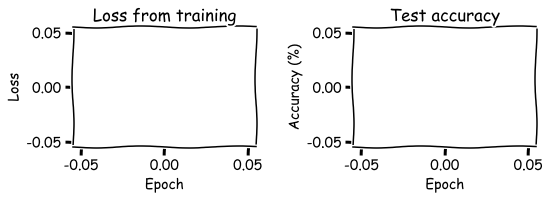

In [310]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(8,3))
plt.xkcd()
axes[0].plot(loss_list, c='r')
axes[0].set_title('Loss from training')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[1].plot(acc_list, c='r')
axes[1].set_title('Test accuracy')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_xlabel('Epoch')
fig.tight_layout()